In [53]:
#importing required modules 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import random
import os

from pyspark.sql import SparkSession 
%matplotlib inline

In [54]:
# loading dataset 
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [55]:
# load the dataset and create sprk dataframe

sql_df = spark.read.csv('dataset/Loan_Train.csv', sep=",", inferSchema=True,header=True)

# Using limit(), or select() or show() to view the data. I often use limit()
# Using toPandas() method to return Pyspark DataFrame as Pandas table

sql_df.limit(5).toPandas()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1,Urban,Y


In [56]:
sql_df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      null|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [57]:
sql_df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [58]:
#For visualization, converting PySpark Dataframe to Pandas DataFrame

#from spark.sql df to Panadas df

data = sql_df.toPandas()

In [59]:
# Describing data
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [60]:
#check datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int32  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int32(1), object(8)
memory usage: 60.1+ KB


In [61]:
# Dropping Loan_ID column
data.drop(['Loan_ID'],axis=1,inplace=True)

## Filling NULL values 

In [62]:
#check null values
data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [63]:
#filling null values

data.Gender.fillna(data['Gender'].mode()[0], inplace=True)

data.Married.fillna(data['Married'].mode()[0], inplace=True)

data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)


data.Self_Employed.fillna(data['Self_Employed'].mode()[0], inplace=True)

data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True) # Mean



data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(), inplace=True)

data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True) # Mode



In [64]:
#now check again null values
data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Exploratory Data Analysis

Number of people who take loan as group by Gender
Male      502
Female    112
Name: Gender, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

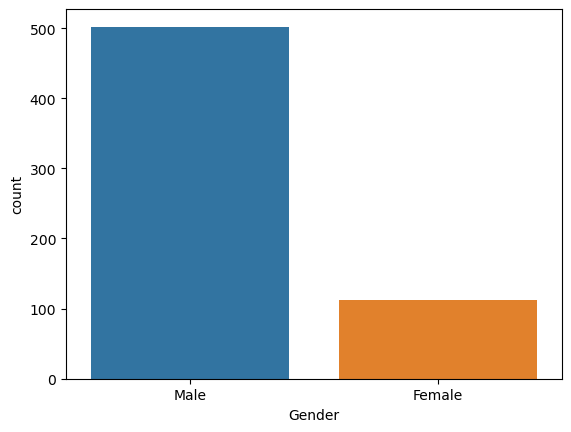

In [65]:
print("Number of people who take loan as group by Gender")
print(data['Gender'].value_counts())
sns.countplot(x="Gender",data=data)

Number of people who take loan as group by marital Status
Yes    401
No     213
Name: Married, dtype: int64


<Axes: xlabel='Married', ylabel='count'>

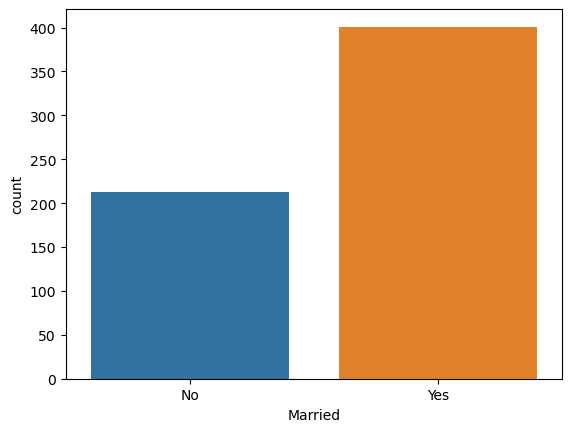

In [66]:
print("Number of people who take loan as group by marital Status")
print(data['Married'].value_counts())
sns.countplot(x="Married",data=data)

Number of people who take loan as group by Dependents
0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64


<Axes: xlabel='Dependents', ylabel='count'>

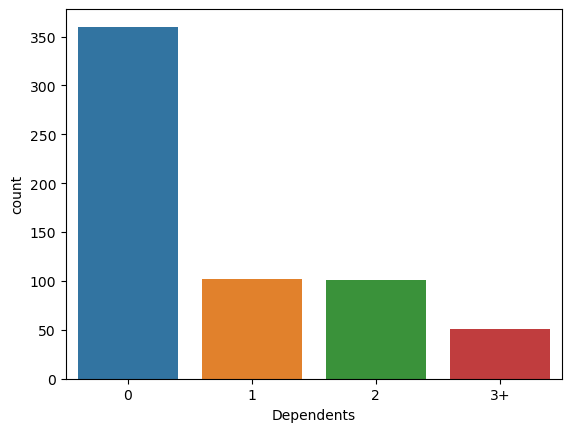

In [67]:
print("Number of people who take loan as group by Dependents")
print(data['Dependents'].value_counts())
sns.countplot(x="Dependents",data=data)

Number of people who take loan as group by Self_Employed
No     532
Yes     82
Name: Self_Employed, dtype: int64


<Axes: xlabel='Self_Employed', ylabel='count'>

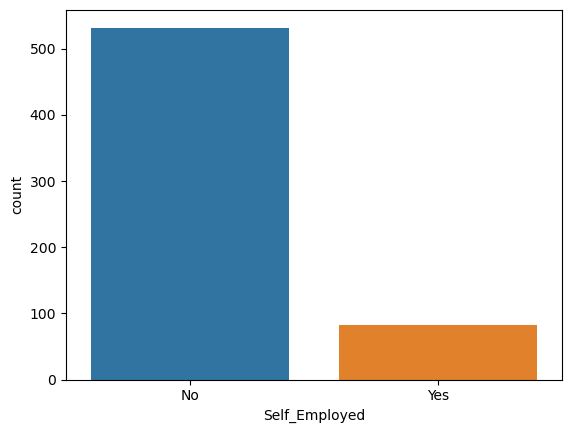

In [68]:
print("Number of people who take loan as group by Self_Employed")
print(data['Self_Employed'].value_counts())
sns.countplot(x="Self_Employed",data=data)

Number of people who take loan as group by Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


(array([0, 1, 2]),
 [Text(0, 0, 'Urban'), Text(1, 0, 'Rural'), Text(2, 0, 'Semiurban')])

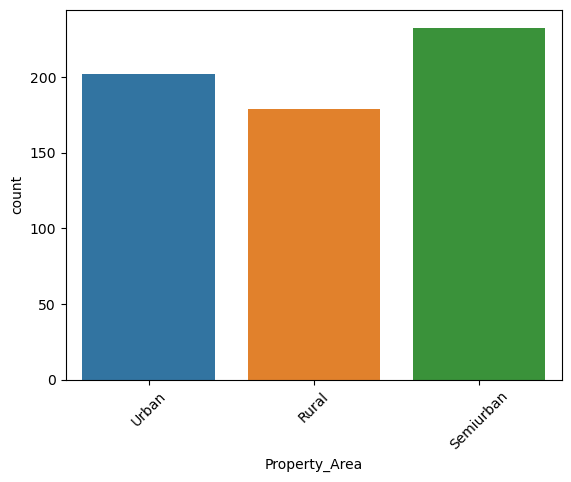

In [69]:
print("Number of people who take loan as group by Property_Area")
print(data['Property_Area'].value_counts())
sns.countplot(x="Property_Area",data=data)
plt.xticks(rotation=45)

Number of people who take loan as group by Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


(array([0, 1]), [Text(0, 0, 'Graduate'), Text(1, 0, 'Not Graduate')])

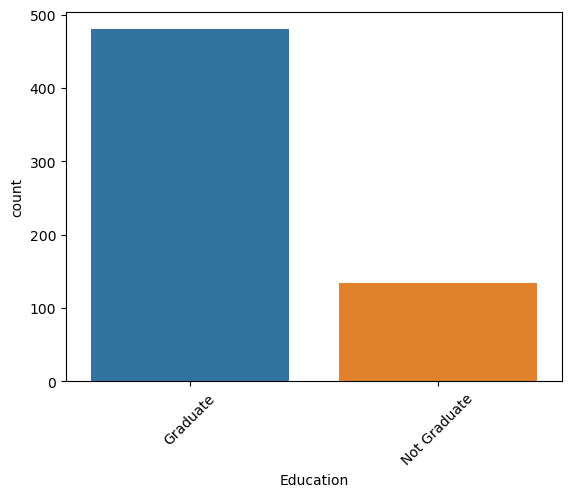

In [70]:
print("Number of people who take loan as group by Education")
print(data['Education'].value_counts())
sns.countplot(x="Education",data=data)
plt.xticks(rotation=45)

Text(0, 0.5, 'Loan Amount')

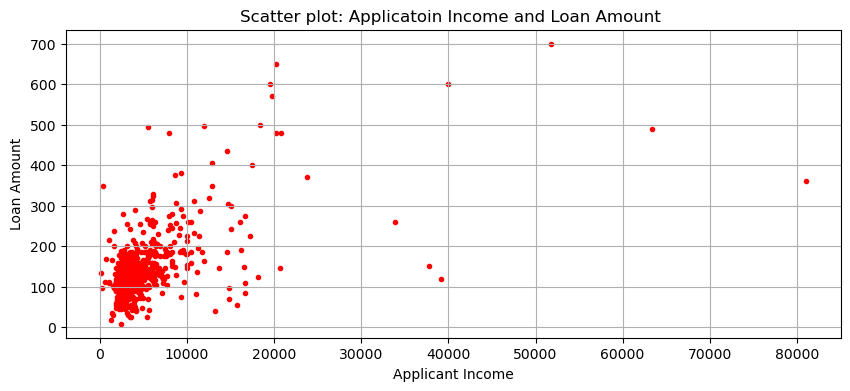

In [71]:
#Applicant income vs loan amount plot
plt.figure(figsize=(10, 4))
plt.title("Scatter plot: Applicatoin Income and Loan Amount ")
plt.grid()
plt.scatter(data['ApplicantIncome'], data['LoanAmount'], c='red', marker='.')
plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount")

Text(0.5, 1.0, 'Histogram Plot: Loan Application Amount ')

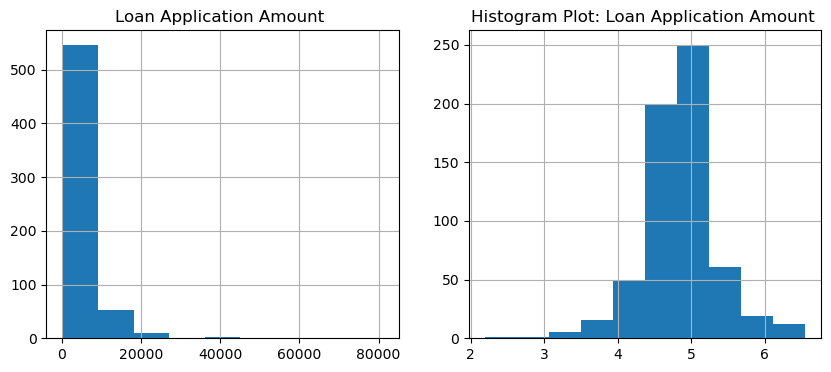

In [72]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
data['ApplicantIncome'].hist(bins=9)
plt.title("Loan Application Amount ")
plt.subplot(1, 2, 2)
plt.grid()
plt.hist(np.log(data['LoanAmount']))
plt.title("Histogram Plot: Loan Application Amount ")

Text(0.5, 1.0, 'Box Plot: Applicant Income ')

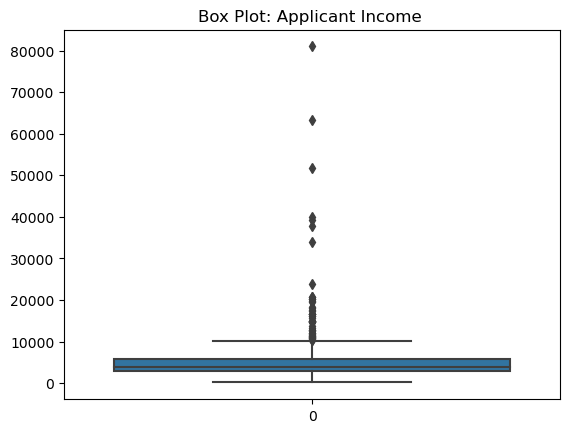

In [73]:
# Box Plot
sns.boxplot(data['ApplicantIncome'])
plt.title("Box Plot: Applicant Income ")

Text(0.5, 1.0, 'Box Plot: Loan Amount ')

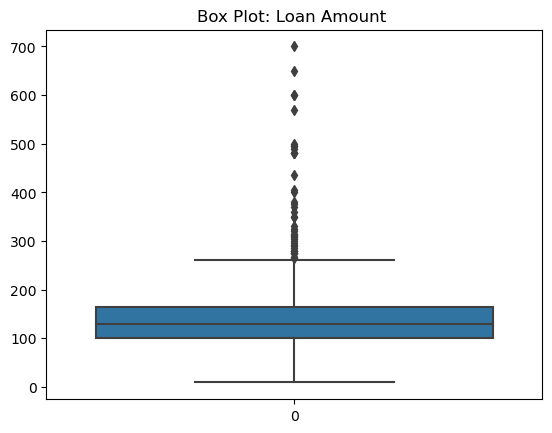

In [74]:
sns.boxplot(data['LoanAmount'])
plt.title("Box Plot: Loan Amount ")

# Splitting Dataset 

In [75]:
X = data.drop(['Loan_Status'],axis=1)
Y = data['Loan_Status']

In [76]:
#spliting train test data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=1)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((429, 11), (185, 11), (429,), (185,))

In [77]:
#training test data
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
81,Male,Yes,1,Graduate,Yes,2395,0.0,146.412162,360.0,1.0,Semiurban
133,Male,Yes,0,Graduate,Yes,3459,0.0,25.000000,120.0,1.0,Semiurban
400,Male,Yes,2,Not Graduate,No,2889,0.0,45.000000,180.0,0.0,Urban
486,Male,No,2,Graduate,No,3547,0.0,80.000000,360.0,0.0,Rural
161,Male,Yes,0,Graduate,No,7933,0.0,275.000000,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
129,Male,Yes,0,Graduate,No,6080,2569.0,182.000000,360.0,1.0,Rural
144,Male,Yes,2,Graduate,No,11757,0.0,187.000000,180.0,1.0,Urban
72,Male,No,0,Graduate,No,3500,0.0,81.000000,300.0,1.0,Semiurban
235,Male,Yes,1,Graduate,No,5500,1260.0,170.000000,360.0,1.0,Rural


In [78]:
Y_train

81     Y
133    Y
400    N
486    N
161    N
      ..
129    N
144    Y
72     Y
235    Y
37     Y
Name: Loan_Status, Length: 429, dtype: object

In [79]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
533,Male,No,1,Graduate,No,11250,0.0,196.0,360.0,1.0,Semiurban
544,Female,Yes,0,Not Graduate,No,3017,663.0,102.0,360.0,1.0,Semiurban
41,Male,No,0,Graduate,No,1800,1213.0,47.0,360.0,1.0,Urban
148,Female,No,0,Graduate,No,10000,1666.0,225.0,360.0,1.0,Rural
111,Female,Yes,0,Graduate,No,2929,2333.0,139.0,360.0,1.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
180,Male,Yes,1,Graduate,No,6400,7250.0,180.0,360.0,0.0,Urban
491,Male,Yes,1,Not Graduate,No,5333,1131.0,186.0,360.0,1.0,Urban
42,Male,Yes,0,Graduate,No,2400,0.0,75.0,360.0,1.0,Urban
530,Male,Yes,0,Graduate,No,1025,5500.0,216.0,360.0,1.0,Rural


In [80]:
Y_test

533    N
544    Y
41     Y
148    N
111    Y
      ..
180    N
491    Y
42     Y
530    Y
457    N
Name: Loan_Status, Length: 185, dtype: object

## convert Categorical variable with Numerical values.

In [81]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [82]:
# Encoding categorical data
# Encoding the Independent Variable

columns = ['Gender','Married','Dependents','Education','Self_Employed']
labelencoder_X = LabelEncoder()
for i,col in enumerate(columns):
    
    X_train[col] = labelencoder_X.fit_transform(X_train.iloc[:,i])

X_train["Property_Area"] = labelencoder_X.fit_transform(X_train.iloc[:,10])

In [83]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_train = labelencoder_y.fit_transform(Y_train)

In [84]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
81,1,1,1,0,1,2395,0.0,146.412162,360.0,1.0,1
133,1,1,0,0,1,3459,0.0,25.000000,120.0,1.0,1
400,1,1,2,1,0,2889,0.0,45.000000,180.0,0.0,2
486,1,0,2,0,0,3547,0.0,80.000000,360.0,0.0,0
161,1,1,0,0,0,7933,0.0,275.000000,360.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
129,1,1,0,0,0,6080,2569.0,182.000000,360.0,1.0,0
144,1,1,2,0,0,11757,0.0,187.000000,180.0,1.0,2
72,1,0,0,0,0,3500,0.0,81.000000,300.0,1.0,1
235,1,1,1,0,0,5500,1260.0,170.000000,360.0,1.0,0


In [85]:
Y_train

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,

In [86]:
# Encoding categorical data (testing data)
# Encoding the Independent Variable

labelencoder_X = LabelEncoder()

for i,col in enumerate(columns):
    X_test[col] = labelencoder_X.fit_transform(X_test.iloc[:,i])

X_test["Property_Area"] = labelencoder_X.fit_transform(X_test.iloc[:,10])
    
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y_test = labelencoder_y.fit_transform(Y_test)

In [87]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
533,1,0,1,0,0,11250,0.0,196.0,360.0,1.0,1
544,0,1,0,1,0,3017,663.0,102.0,360.0,1.0,1
41,1,0,0,0,0,1800,1213.0,47.0,360.0,1.0,2
148,0,0,0,0,0,10000,1666.0,225.0,360.0,1.0,0
111,0,1,0,0,0,2929,2333.0,139.0,360.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
180,1,1,1,0,0,6400,7250.0,180.0,360.0,0.0,2
491,1,1,1,1,0,5333,1131.0,186.0,360.0,1.0,2
42,1,1,0,0,0,2400,0.0,75.0,360.0,1.0,2
530,1,1,0,0,0,1025,5500.0,216.0,360.0,1.0,0


In [88]:
Y_test

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0])

In [89]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Model Training and Evaluation

In [90]:


def model_report(models,X_train,X_test,y_train,y_test):
    for name, model in models:
        model.fit(X_train, y_train)
        y_hat_train = model.predict(X_train)
        y_hat_test  = model.predict(X_test)
        print("_"*80)
        print(f"Report For {name}".center(80))
        print()
        print(f"Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}")
        print(f"Test     Accuracy: {accuracy_score(y_test, y_hat_test):.2f}")
        print()
        #print(f"Training Accuracy: {confusion_matrix(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {confusion_matrix(y_test, y_hat_test)}")
        print()
        print(f"Training Accuracy: {classification_report(y_train, y_hat_train)}")
        print(f"Test     Accuracy: {classification_report(y_test, y_hat_test)}")
        print('\n\n')

In [107]:
#Preparing different models
  
knn = KNeighborsClassifier()
rfc = RandomForestClassifier(max_depth=2, random_state=10)
svc = SVC()
lc = LogisticRegression()
classifier = GaussianNB()
dt = DecisionTreeClassifier(max_depth=3, min_samples_split=3, min_samples_leaf=1, random_state=1)


model = [
    ('LogisticRegression',lc),
    ('KNeighborsClassifier',knn),
    ('svc',svc),
    ('RandomForestClassifier',rfc),
    ('GaussianNB',classifier),
    ('DecisionTreeClassifier',dt)
]

In [108]:
model_report(model,X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                         Report For LogisticRegression                          

Training Accuracy: 0.82
Test     Accuracy: 0.79

Test     Accuracy: [[ 25  36]
 [  2 122]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.92      0.45      0.61       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.86      0.72      0.74       429
weighted avg       0.84      0.82      0.80       429

Test     Accuracy:               precision    recall  f1-score   support

           0       0.93      0.41      0.57        61
           1       0.77      0.98      0.87       124

    accuracy                           0.79       185
   macro avg       0.85      0.70      0.72       185
weighted avg       0.82      0.79      0.77       185




__________________________________________________

## Model Optimization 

In [93]:
from sklearn.model_selection import GridSearchCV

In [109]:
param_grid = {
'n_estimators': [25, 50, 100, 150],
'max_features': ['sqrt', 'log2', None],
'max_depth': [3, 6, 9],
'max_leaf_nodes': [3, 6, 9],
}

forest = RandomForestClassifier(n_jobs=-1)

grid_search = GridSearchCV(forest, param_grid, cv=5,
                      scoring="accuracy", return_train_score=True)

In [110]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True, scoring='accuracy')

In [111]:
best_model = grid_search.best_estimator_

In [112]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 50}


In [113]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 50}


In [118]:
result = grid_search.cv_results_
result

{'mean_fit_time': array([0.37529883, 0.02649422, 0.05121088, 0.07081785, 0.01568356,
        0.0261848 , 0.04835091, 0.07668395, 0.01638026, 0.02655792,
        0.05080423, 0.07228537, 0.01674418, 0.02631702, 0.04793067,
        0.07165627, 0.01590681, 0.02609   , 0.04920034, 0.07678008,
        0.01622925, 0.02551813, 0.05036283, 0.07474704, 0.01627693,
        0.0268599 , 0.05216584, 0.0791882 , 0.01770892, 0.02724814,
        0.05301661, 0.07860713, 0.01686902, 0.02749605, 0.05498667,
        0.08061938, 0.01856389, 0.03008103, 0.07509255, 0.07258868,
        0.01615558, 0.0310698 , 0.05782709, 0.08145118, 0.01839671,
        0.03016047, 0.05049548, 0.07288699, 0.0168952 , 0.02821145,
        0.05243607, 0.07359657, 0.0162096 , 0.02576461, 0.05158296,
        0.07182083, 0.01676064, 0.02681856, 0.04960842, 0.07392998,
        0.01628366, 0.02737594, 0.05186963, 0.07512913, 0.01667509,
        0.02749453, 0.0528142 , 0.07668157, 0.01756182, 0.02846332,
        0.05361071, 0.08534055,

In [115]:
print(list(result.keys()))

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_max_leaf_nodes', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score']


In [116]:

train_scores = result['mean_train_score']
test_scores  = result['mean_test_score']
parameters = result['params']


scores = [ (tr, ts, pr) for tr, ts, pr in zip(train_scores, test_scores, parameters) ]


strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores):
    print(strformat.format(ix+1, tr, ts, pr, lb))

|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.818179198589735  |  0.8134610123119016 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|2    | 0.818179198589735  |  0.818139534883721  | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|3    | 0.818760593938572  |  0.818139534883721  | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'n_estimators': 100}|
______________________________________________________________________________________________________________

|4    | 0.818179198589735  |  0.818139534883721  | {'max_depth': 3, 'max_features': 's

In [117]:
scores.sort(key=lambda x: x[1],reverse=True)

print("Top 10 Models")
strformat = "|{:<5}|{:^20}| {:^20}| {}|\n{}\n"
lb =  '_'*110
print(strformat.format("", "Training Score", "Test Score", "Parameters", lb))
for ix, (tr, ts, pr) in enumerate(scores[:10]):
    print(strformat.format(ix+1, tr, ts, pr, lb))
    

Top 10 Models
|     |   Training Score   |      Test Score     | Parameters|
______________________________________________________________________________________________________________

|1    | 0.8222574411824531 |  0.8204651162790698 | {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|2    | 0.8222608312427961 |  0.8204651162790698 | {'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': 6, 'n_estimators': 25}|
______________________________________________________________________________________________________________

|3    | 0.8205081700454269 |  0.8204651162790698 | {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 50}|
______________________________________________________________________________________________________________

|4    | 0.8210912604244356 |  0.8204651162790698 | {'max_depth': 6, 'max_

### Final best value

In [103]:
rfc = RandomForestClassifier(n_jobs=-1,max_depth= 3, max_features= 'sqrt', max_leaf_nodes= 9, n_estimators= 25)

In [104]:
model_report([("RandomForestClassifier",rfc)],X_train,X_test,Y_train,Y_test)

________________________________________________________________________________
                       Report For RandomForestClassifier                        

Training Accuracy: 0.82
Test     Accuracy: 0.79

Test     Accuracy: [[ 25  36]
 [  2 122]]

Training Accuracy:               precision    recall  f1-score   support

           0       0.94      0.45      0.61       131
           1       0.80      0.99      0.89       298

    accuracy                           0.82       429
   macro avg       0.87      0.72      0.75       429
weighted avg       0.84      0.82      0.80       429

Test     Accuracy:               precision    recall  f1-score   support

           0       0.93      0.41      0.57        61
           1       0.77      0.98      0.87       124

    accuracy                           0.79       185
   macro avg       0.85      0.70      0.72       185
weighted avg       0.82      0.79      0.77       185




